In [33]:
import sys
import requests
import json
import datetime
import os
import pandas as pd
import numpy as np
import os
from dateutil.relativedelta import relativedelta
import pytz
import matplotlib.dates as mdates
import json
import math
import ast
from sys import stdout as out
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [34]:
def get_dev_info(device, address):
    
    r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']
    
    # get devid by serial name
    r1 = requests.get(
        url=address + "/api/tenant/devices?deviceName=" + device,
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    label = r1['label']
    devid = r1['id']['id']
    r1 = requests.get(
        url=address + "/api/device/" + devid + "/credentials",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    devtoken = r1['credentialsId']

    
    
    return devid,devtoken,acc_token,label
    
    

def get_attr(acc_token,devid,address):
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/attributes?keys=nominal",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    nominal = r2[0]['value']

    return nominal





def read_data(acc_token, devid, address, start_time, end_time, descriptors):

        
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    if r2:
        df = pd.DataFrame([])
        
        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            
            df1.reset_index(drop=False, inplace=True)
            df1['ts'] = pd.to_datetime(df1['ts'], unit='ms')
            df1['ts'] = df1['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
            df1 = df1.sort_values(by=['ts'])
            df1.reset_index(drop=True, inplace=True)
            df1.set_index('ts', inplace=True, drop=True)            
            
            df = pd.concat([df, df1], axis=1)

        if df.empty:
            df = pd.DataFrame([])
        else:
            for col in df.columns:
                df[col] = df[col].astype('float64')
    else:
        df = pd.DataFrame([])
        # print('Empty json!')
    return df


In [83]:
os.getcwd()

'c:\\Projects\\testmeazon'

finished reading
df before:                curA          curB          curC          vltA          vltB  \
count  16177.000000  16177.000000  16177.000000  16177.000000  16177.000000   
mean     276.932556    272.050134    375.237291    240.481444    239.042912   
std       85.747283     89.995675    109.950471      1.780442      1.963328   
min      128.345000    116.131000    174.936000    234.709000    233.199000   
25%      206.396000    196.247000    285.989000    239.242000    237.544000   
50%      266.655000    258.473000    349.021000    240.550000    239.029000   
75%      337.340000    341.766000    447.986000    241.789000    240.568000   
max      625.182000    527.675000    748.061000    244.691000    244.055000   

               vltC          kfac      totalcur      totalvlt      totalapwr  
count  16177.000000  15279.000000  16177.000000  16177.000000   16177.000000  
mean     238.531170      0.825712    924.219981    239.351842  220907.375804  
std        1.937111    

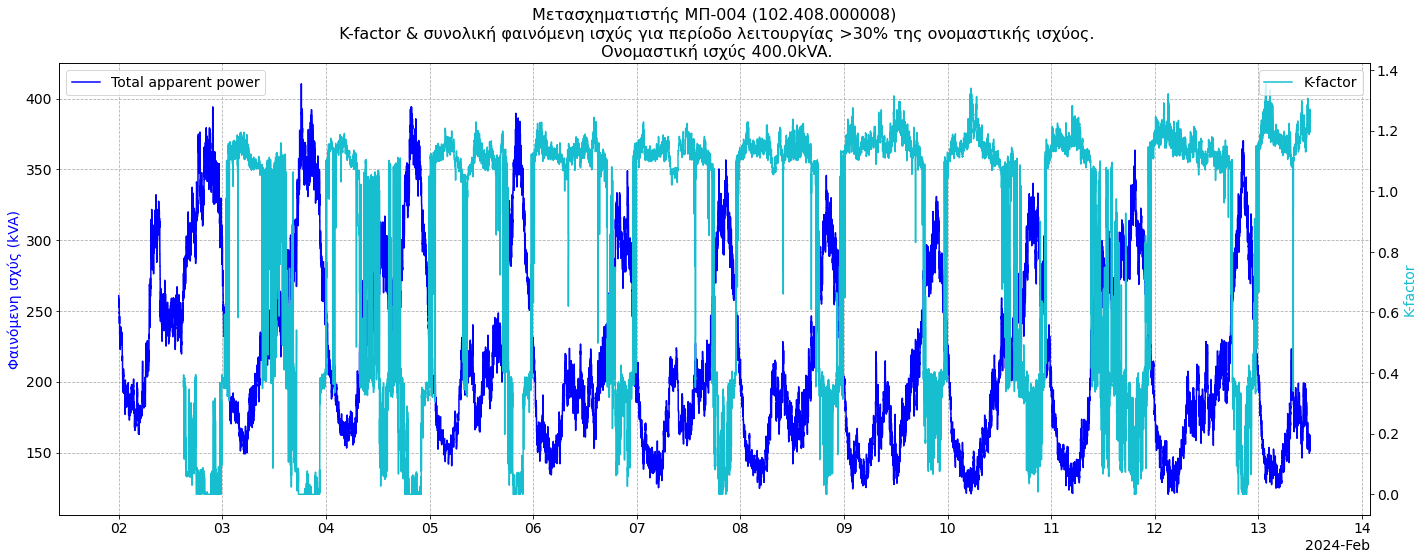

In [91]:
# KFACTOR

address = 'https://mi6.meazon.com'

r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
acc_token = 'Bearer' + ' ' + r['token']


entityId = '4795fc10-5b7f-11ee-b2c9-653b42f73605' # DEDDHE ATHINAS
r1 = requests.get(url=address + "/api/entityGroup/"+entityId+"/entities?pageSize=1000&page=0",headers={'Content-Type': 'application/json', 
'Accept': '*/*', 'X-Authorization': acc_token}).json()

assetid = 'b9cc57e0-7cac-11ee-b97f-098b03a95eb1'
assetname = 'ΜΠ-051 Κ/Δ ΠΑΛΛΗΝΗΣ'


device = '102.408.000008'

# Define variables
# device = '102.408.000008'
local_tz = pytz.timezone('Europe/Athens')
interval = 1
descriptors = 'curA,curB,curC,vltA,vltB,vltC,kfac'
start_time = '1706824800000'
end_time = '1707818400000'

# extract info
[devid, _, acc_token,label] = get_dev_info(device, address)


nominal = get_attr(acc_token,devid,address)


# read data
timethres = 12*3600000
svec = np.arange(int(start_time),int(end_time),timethres)

df = pd.DataFrame([])

for st in svec:
    en = st+timethres-1
    
    if int(end_time)-en<=0: en = int(end_time)
    tmp = read_data(acc_token, devid, address,  str(st), str(en), descriptors)
    if not tmp.empty:
        tmp = tmp.resample(str(interval)+'T').mean()
        # tmp = tmp.dropna()
        df = pd.concat([df,tmp])

del tmp
df.sort_index(inplace=True)
print('finished reading')
# calculate new variables



df['totalcur'] = df['curA']+df['curB']+df['curC']
df['totalvlt'] = (df['vltA']+df['vltB']+df['vltC'])/3
df['totalapwr'] = df['totalvlt']*df['totalcur']
nomphase = 1000*nominal

# Find power alarms

# df['pwrAlarm'] = np.nan
# df.loc[df['totalapwr']>0.8*nomphase, 'pwrAlarm'] = 1
print('df before:',df.describe())
df = df.loc[df['totalapwr']>0.3*nomphase]
print('df after:',df.describe())



# Plot power alarms


local_tz = pytz.timezone('Europe/Athens')
fig, ax = plt.subplots(figsize=(20, 8.0))
plt.step(df.index,df['totalapwr']/1000,color='b',label="Total apparent power")
ax.legend(loc=2)
ax.set_ylabel('Φαινόμενη ισχύς (kVA)', color='b')

ax2 = ax.twinx()
ax2.step(df.index,df['kfac'], color="tab:cyan", label="K-factor")
ax2.set_ylabel('K-factor', color='tab:cyan')
ax2.legend(loc=1)

# plt.setp(ax.xaxis.get_majorticklabels())
# plt.step(df.index, df['apwrA'], where='post')

plt.xlabel('Ημ/νία')

# filtered = df['alarmA']>=1
# ax.scatter(df.index[filtered], df['apwrA'][filtered], color='red') 

ax.xaxis.set( 
major_locator = mdates.AutoDateLocator(minticks = 1, 
                                        maxticks = 5,tz=local_tz), 
) 

locator = mdates.AutoDateLocator(minticks = 5, 
                                maxticks = 20,tz=local_tz) 
formatter = mdates.ConciseDateFormatter(locator,tz=local_tz) 


ax.grid(linestyle = "dashed")
ax.xaxis.set_major_locator(locator) 
ax.xaxis.set_major_formatter(formatter)
ax.set_title('Μετασχηματιστής '+str(label)+' ('+str(device)+')\n K-factor & συνολική φαινόμενη ισχύς για περίοδο λειτουργίας >30% της ονομαστικής ισχύος.\n Ονομαστική ισχύς '+str(nomphase/1000)+'kVA.')
ax.title.set_size(16)
fig.tight_layout()
plt.savefig('kfactor'+'.png',dpi=150)




finished reading


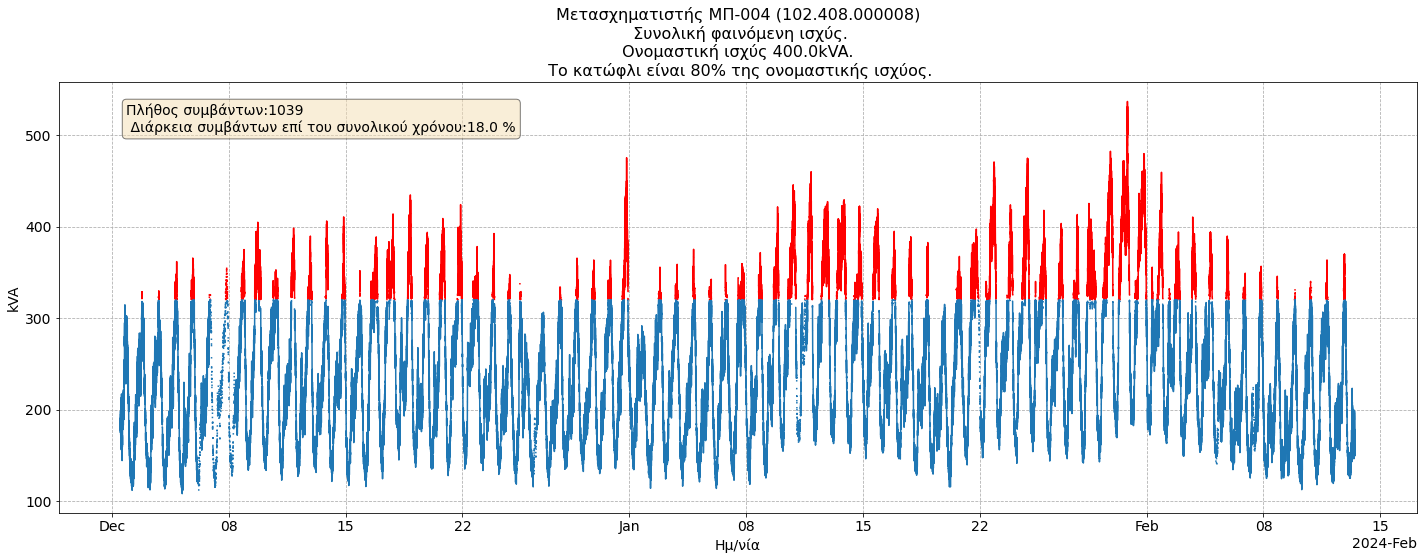

In [85]:
# TOTAL APWR
address = 'https://mi6.meazon.com'

r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
acc_token = 'Bearer' + ' ' + r['token']


entityId = '4795fc10-5b7f-11ee-b2c9-653b42f73605' # DEDDHE ATHINAS
r1 = requests.get(url=address + "/api/entityGroup/"+entityId+"/entities?pageSize=1000&page=0",headers={'Content-Type': 'application/json', 
'Accept': '*/*', 'X-Authorization': acc_token}).json()

assetid = 'b9cc57e0-7cac-11ee-b97f-098b03a95eb1'
assetname = 'ΜΠ-051 Κ/Δ ΠΑΛΛΗΝΗΣ'


device = '102.408.000008'

# Define variables
# device = '102.408.000008'
local_tz = pytz.timezone('Europe/Athens')
interval = 1
descriptors = 'curA,curB,curC,vltA,vltB,vltC'
start_time = '1701424800000'
end_time = '1707818400000'

# extract info
[devid, _, acc_token,label] = get_dev_info(device, address)


nominal = get_attr(acc_token,devid,address)


# read data
timethres = 12*3600000
svec = np.arange(int(start_time),int(end_time),timethres)

df = pd.DataFrame([])

for st in svec:
    en = st+timethres-1
    
    if int(end_time)-en<=0: en = int(end_time)
    tmp = read_data(acc_token, devid, address,  str(st), str(en), descriptors)
    if not tmp.empty:
        tmp = tmp.resample(str(interval)+'T').mean()
        # tmp = tmp.dropna()
        df = pd.concat([df,tmp])

del tmp
df.sort_index(inplace=True)
print('finished reading')
# calculate new variables



df['totalcur'] = df['curA']+df['curB']+df['curC']
df['totalvlt'] = (df['vltA']+df['vltB']+df['vltC'])/3
df['totalapwr'] = df['totalvlt']*df['totalcur']
nomphase = 1000*nominal

# Find power alarms

df['pwrAlarm'] = np.nan
df.loc[df['totalapwr']>0.8*nomphase, 'pwrAlarm'] = 1

# create groups
ind=0
df['alarm'] = np.nan
for i in range(1,df.shape[0]):
    if ((df['pwrAlarm'].iloc[i]==1) & (df['pwrAlarm'].iloc[i-1]!=1)):
        ind+=1
        df['alarm'].iloc[i]=ind
    elif((df['pwrAlarm'].iloc[i]==1) & (df['pwrAlarm'].iloc[i-1]==1)):
        df['alarm'].iloc[i]=ind


# Plot power alarms
#overall duration within time range
dtPerc = 100*np.round(df.describe()['alarm']['count']/df.describe()['totalcur']['count'],2)
# number of distinct events/alarms
events = df.groupby('alarm').ngroups

local_tz = pytz.timezone('Europe/Athens')
fig, ax = plt.subplots(figsize=(20, 8.0))

plt.step(df.index,np.where(df['pwrAlarm']==1,df['totalapwr']/1000, None), color="red", label="1")
plt.step(df.index,np.where(df['pwrAlarm']!=1,df['totalapwr']/1000, None), color="tab:blue", label="1")

# plt.setp(ax.xaxis.get_majorticklabels())
# plt.step(df.index, df['apwrA'], where='post')

plt.xlabel('Ημ/νία')
plt.ylabel('kVA')

# filtered = df['alarmA']>=1
# ax.scatter(df.index[filtered], df['apwrA'][filtered], color='red') 

ax.xaxis.set( 
major_locator = mdates.AutoDateLocator(minticks = 1, 
                                        maxticks = 5,tz=local_tz), 
) 

locator = mdates.AutoDateLocator(minticks = 5, 
                                maxticks = 20,tz=local_tz) 
formatter = mdates.ConciseDateFormatter(locator,tz=local_tz) 

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = 'Πλήθος συμβάντων:'+str(events)+'\n Διάρκεια συμβάντων επί του συνολικού χρόνου:'+str(dtPerc)+' %'

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)
ax.grid(linestyle = "dashed")
ax.xaxis.set_major_locator(locator) 
ax.xaxis.set_major_formatter(formatter)
ax.set_title('Μετασχηματιστής '+str(label)+' ('+str(device)+')\n Συνολική φαινόμενη ισχύς.\n Ονομαστική ισχύς '+str(nomphase/1000)+'kVA. \n Το κατώφλι είναι 80% της ονομαστικής ισχύος.')
ax.title.set_size(16)
fig.tight_layout()
plt.savefig('totalpwrAlarm'+'.png',dpi=150)




In [35]:
address = 'https://mi6.meazon.com'

r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
acc_token = 'Bearer' + ' ' + r['token']


entityId = '4795fc10-5b7f-11ee-b2c9-653b42f73605' # DEDDHE ATHINAS
r1 = requests.get(url=address + "/api/entityGroup/"+entityId+"/entities?pageSize=1000&page=0",headers={'Content-Type': 'application/json', 
'Accept': '*/*', 'X-Authorization': acc_token}).json()

assetid = 'b9cc57e0-7cac-11ee-b97f-098b03a95eb1'
assetname = 'ΜΠ-051 Κ/Δ ΠΑΛΛΗΝΗΣ'


device = '102.408.000008'

# Define variables
# device = '102.408.000008'
local_tz = pytz.timezone('Europe/Athens')
interval = 1
descriptors = 'curA,curB,curC,vltA,vltB,vltC'
start_time = '1701424800000'
end_time = '1707818400000'

# extract info
[devid, _, acc_token,label] = get_dev_info(device, address)

if not os.path.exists(label+'_'+str(device)):
    os.makedirs(label+'_'+str(device))
    os.chdir(label+'_'+str(device))

    nominal = get_attr(acc_token,devid,address)


    # read data
    timethres = 12*3600000
    svec = np.arange(int(start_time),int(end_time),timethres)

    df = pd.DataFrame([])

    for st in svec:
        en = st+timethres-1
        
        if int(end_time)-en<=0: en = int(end_time)
        tmp = read_data(acc_token, devid, address,  str(st), str(en), descriptors)
        if not tmp.empty:
            tmp = tmp.resample(str(interval)+'T').mean()
            # tmp = tmp.dropna()
            df = pd.concat([df,tmp])

    del tmp
    df.sort_index(inplace=True)

    # calculate new variables
    for ph in ['A','B','C']:
        df['apwr'+ph] = df['vlt'+ph]*df['cur'+ph]

    df['totalcur'] = df['curA']+df['curB']+df['curC']
    nomphase = 1000*np.round(nominal/3,2)

    # Find power alarms
    for ph in ['A','B','C']:
        df['pwrAlarm'+ph] = np.nan
        df.loc[df['apwr'+ph]>0.8*nomphase, 'pwrAlarm'+ph] = 1

    # create groups
    for ph in ['A','B','C']:
        ind=0
        df['alarm'+ph] = np.nan
        for i in range(1,df.shape[0]):
            if ((df['pwrAlarm'+ph].iloc[i]==1) & (df['pwrAlarm'+ph].iloc[i-1]!=1)):
                ind+=1
                df['alarm'+ph].iloc[i]=ind
            elif((df['pwrAlarm'+ph].iloc[i]==1) & (df['pwrAlarm'+ph].iloc[i-1]==1)):
                df['alarm'+ph].iloc[i]=ind


    # Plot power alarms
    for ph in ['A','B','C']:
        #overall duration within time range
        dtPerc = 100*np.round(df.describe()['alarm'+ph]['count']/df.describe()['cur'+ph]['count'],2)
        # number of distinct events/alarms
        events = df.groupby('alarm'+ph).ngroups

        local_tz = pytz.timezone('Europe/Athens')
        fig, ax = plt.subplots(figsize=(20, 8.0))

        plt.step(df.index,np.where(df['pwrAlarm'+ph]==1,df['apwr'+ph]/1000, None), color="red", label="1")
        plt.step(df.index,np.where(df['pwrAlarm'+ph]!=1,df['apwr'+ph]/1000, None), color="tab:blue", label="1")

        # plt.setp(ax.xaxis.get_majorticklabels())
        # plt.step(df.index, df['apwrA'], where='post')

        plt.xlabel('Ημ/νία')
        plt.ylabel('kVA')

        # filtered = df['alarmA']>=1
        # ax.scatter(df.index[filtered], df['apwrA'][filtered], color='red') 

        ax.xaxis.set( 
        major_locator = mdates.AutoDateLocator(minticks = 1, 
                                                maxticks = 5,tz=local_tz), 
        ) 

        locator = mdates.AutoDateLocator(minticks = 5, 
                                        maxticks = 20,tz=local_tz) 
        formatter = mdates.ConciseDateFormatter(locator,tz=local_tz) 

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        textstr = 'Πλήθος συμβάντων:'+str(events)+'\n Διάρκεια συμβάντων επί του συνολικού χρόνου:'+str(dtPerc)+' %'
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        ax.grid(linestyle = "dashed")
        ax.xaxis.set_major_locator(locator) 
        ax.xaxis.set_major_formatter(formatter)
        ax.set_title('Μετασχηματιστής '+str(label)+' ('+str(device)+')\n Φαινόμενη ισχύς φάσης '+ph+'.\n Ονομαστική ισχύς ανά φάση '+str(nomphase/1000)+'kVA. \n Το κατώφλι είναι 80% της ονομαστικής ισχύος.')
        ax.title.set_size(16)
        fig.tight_layout()
        # plt.savefig('pwrAlarm'+str(ph)+'.png',dpi=150)

    os.chdir('..')


In [36]:
print(df.describe()['alarmA']['count'],df.describe()['apwrA']['count'])


12077.0 103413.0


In [37]:
dtPercA = 100*df.describe()['alarmA']['count']/df.describe()['curA']['count']
dtPercB = 100*df.describe()['alarmB']['count']/df.describe()['curB']['count']
dtPercC = 100*df.describe()['alarmC']['count']/df.describe()['curC']['count']

eventsA = df.groupby('alarmA').ngroups
eventsB = df.groupby('alarmB').ngroups
eventsC = df.groupby('alarmC').ngroups



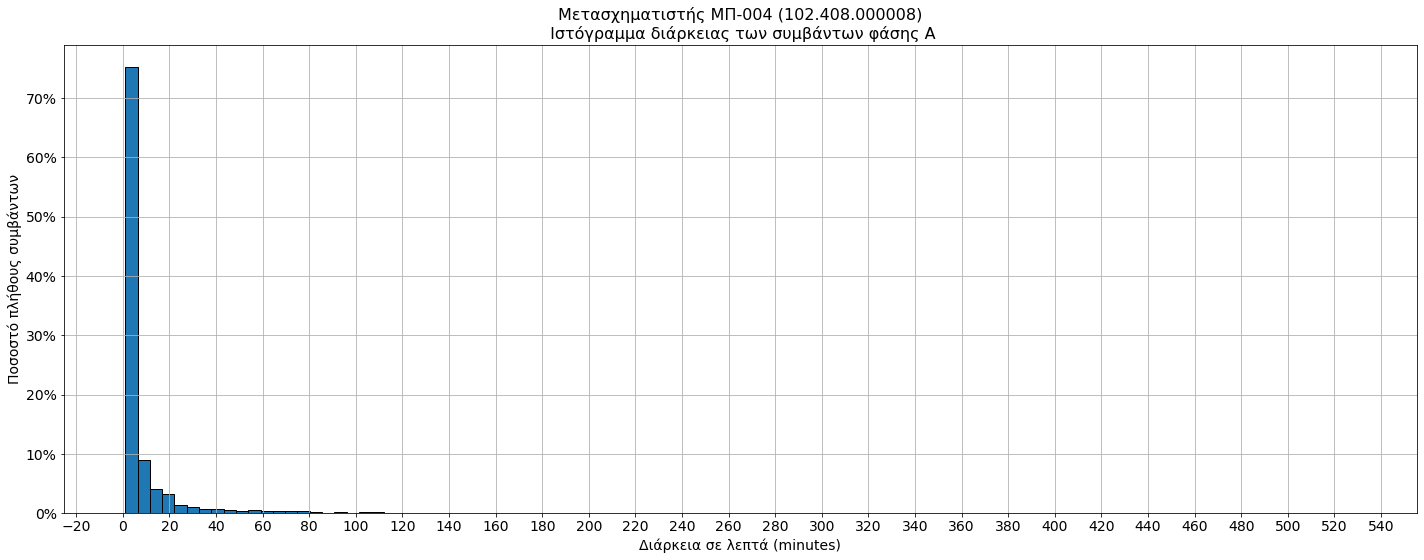

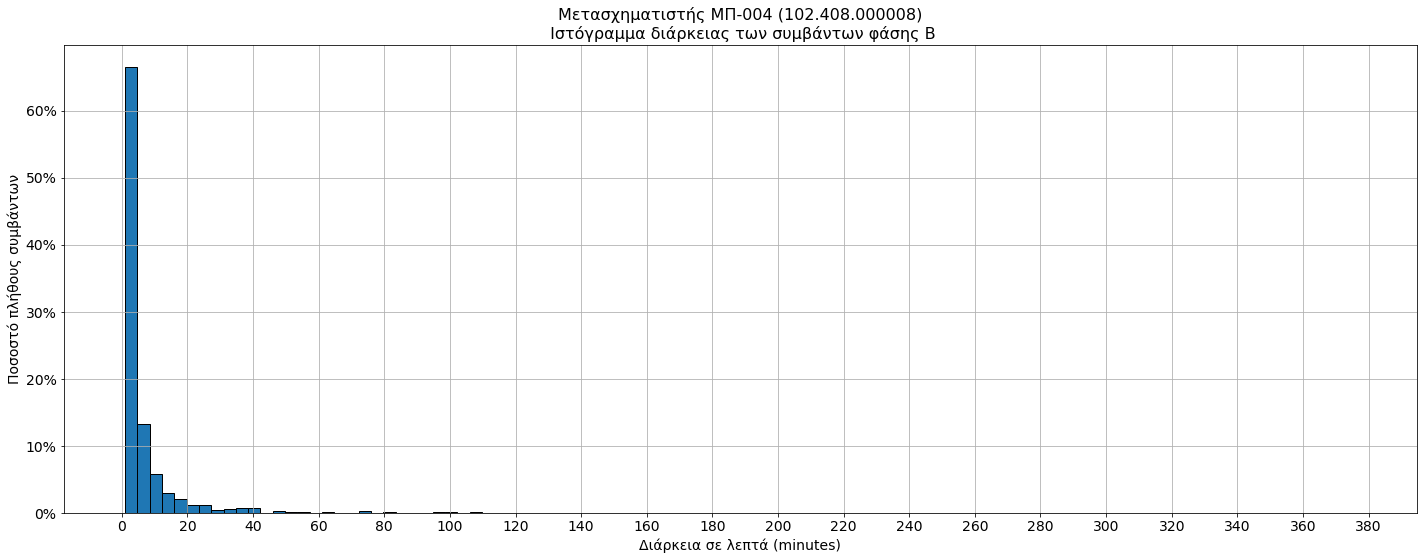

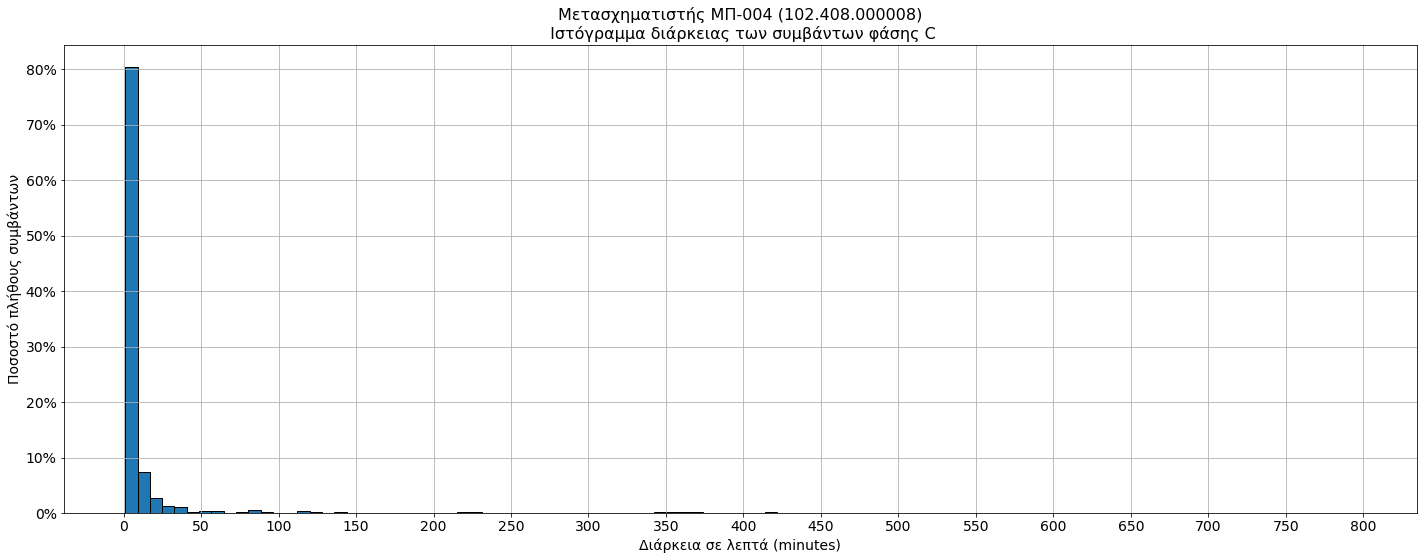

In [64]:
from matplotlib.ticker import PercentFormatter

for ph in ['A','B','C']:
    fig,ax = plt.subplots(figsize=(20, 8.0))
    # df.groupby('alarm'+ph).size().boxplot()
    df.groupby('alarm'+ph).size().hist(bins=100, weights=np.ones(len(df.groupby('alarm'+ph).size())) / len(df.groupby('alarm'+ph).size()), figsize=[20,8],edgecolor='black')
    ax.set_xlabel('Διάρκεια σε λεπτά (minutes)')
    ax.set_ylabel('Ποσοστό πλήθους συμβάντων')
    ax.set_title('Μετασχηματιστής '+str(label)+' ('+str(device)+')\n Ιστόγραμμα διάρκειας των συμβάντων φάσης '+ph)
    ax.locator_params(nbins=30, axis='x')
    ax.title.set_size(16)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    fig.tight_layout()
    plt.savefig('hist'+ph+'.png',dpi=150)


1268

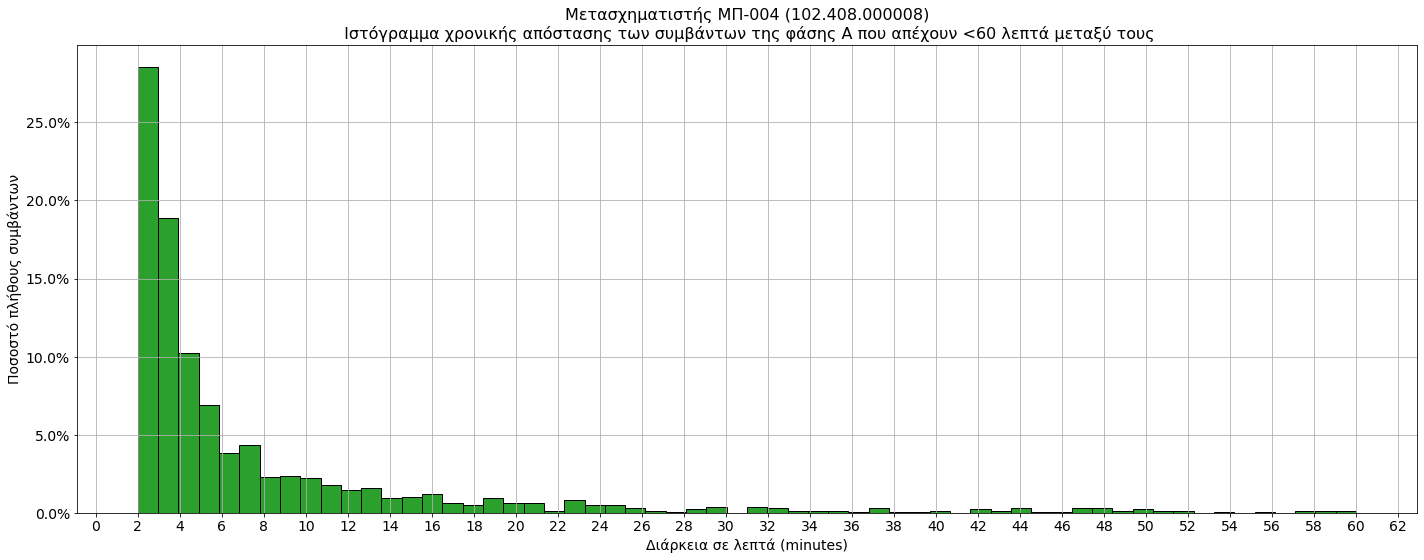

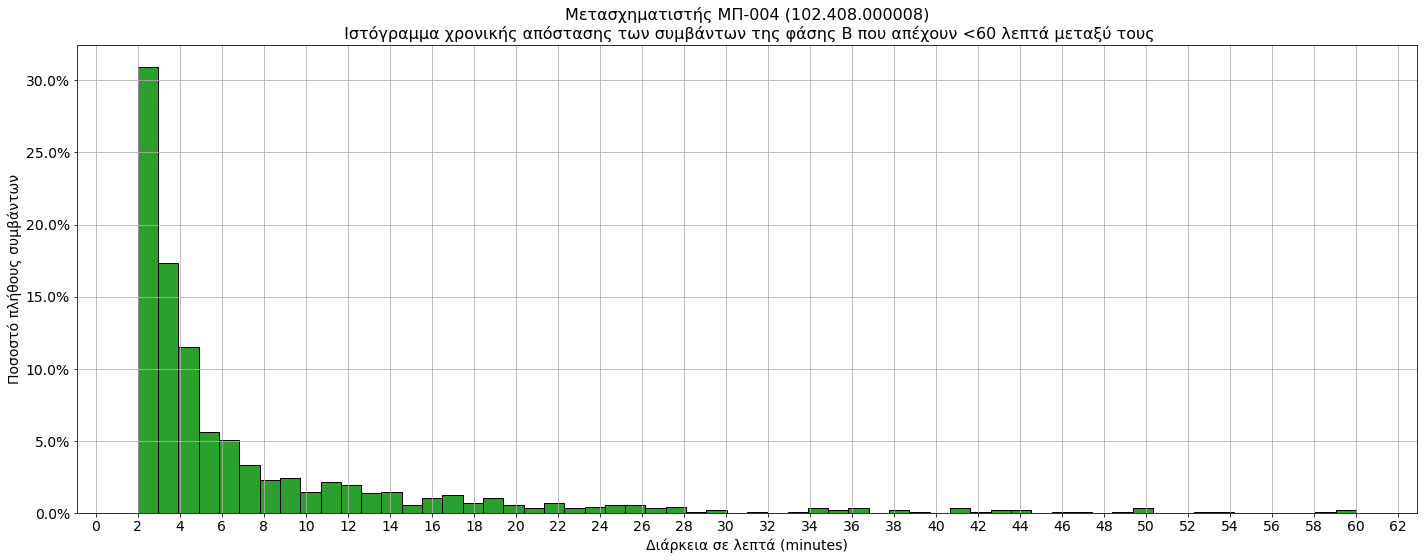

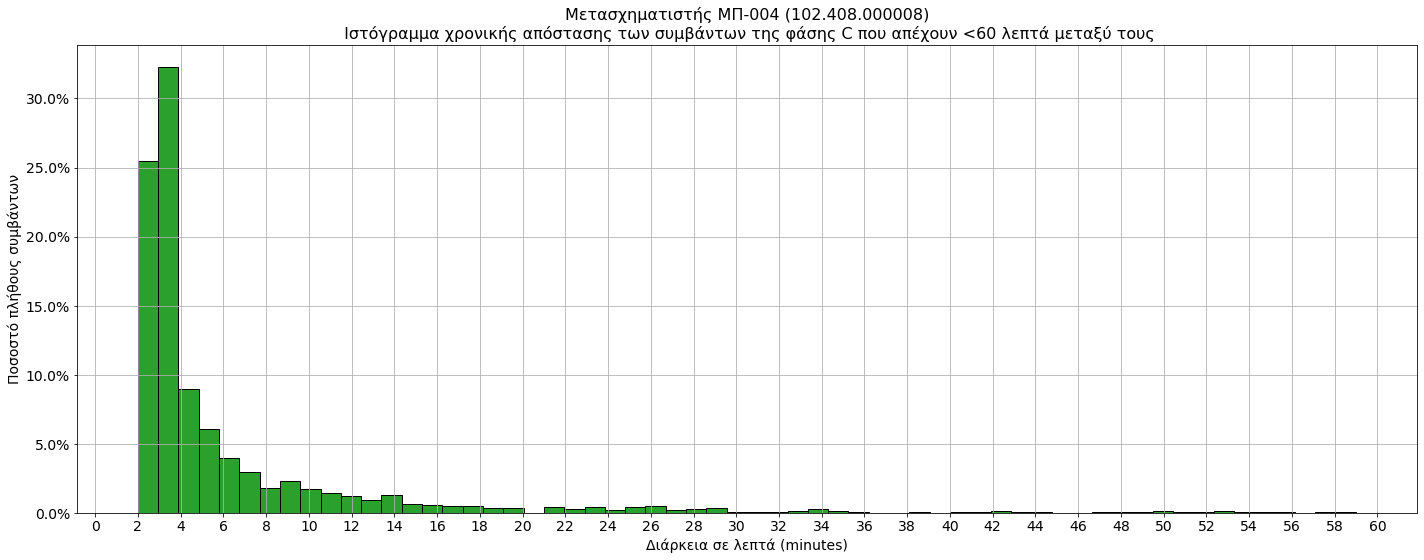

In [81]:
for ph in ['A','B','C']:
    tmp = df.loc[df['alarm'+ph]>0,['alarm'+ph]].copy()
    tmp['timedif'] = tmp.index.to_series().diff().astype('timedelta64[m]')
    tmp = tmp.loc[tmp['alarm'+ph]!=tmp['alarm'+ph].shift()]
    tmp = tmp.iloc[1:]

    # keep only events with timedif smaller than 60min
    tmp = tmp.loc[tmp['timedif']<=60]
    fig,ax = plt.subplots(figsize=(20, 8.0))
    # df.groupby('alarm'+ph).size().boxplot()
    tmp['timedif'].hist(bins=60, weights=np.ones(len(tmp)) / len(tmp), figsize=[20,8],edgecolor='black', color='tab:green')
    ax.set_xlabel('Διάρκεια σε λεπτά (minutes)')
    ax.set_ylabel('Ποσοστό πλήθους συμβάντων')
    ax.set_title('Μετασχηματιστής '+str(label)+' ('+str(device)+')\n Ιστόγραμμα χρονικής απόστασης των συμβάντων της φάσης '+ph+' που απέχουν <60 λεπτά μεταξύ τους')
    ax.locator_params(nbins=60, axis='x')
    ax.title.set_size(16)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    fig.tight_layout()
    plt.savefig('timehist'+ph+'.png',dpi=150)



In [67]:
πη='Α'
tmp = df.loc[df['alarm'+ph]>0,['alarm'+ph]].copy()
tmp['timedif'] = tmp.index.to_series().diff().astype('timedelta64[m]')
tmp = tmp.loc[tmp['alarm'+ph]!=tmp['alarm'+ph].shift()]
tmp = tmp.iloc[1:]

# keep only events with timedif smaller than 60min
tmp = tmp.loc[tmp['timedif']<=60]
tmp.sort_values(by='timedif')


,alarmC,timedif
ts,,
2023-12-27 19:26:00+02:00,648.0,2.0
2023-12-25 12:16:00+02:00,599.0,2.0
2023-12-25 13:36:00+02:00,609.0,2.0
2024-01-27 21:02:00+02:00,1395.0,2.0
2024-01-27 19:30:00+02:00,1394.0,2.0
2024-02-03 11:48:00+02:00,1510.0,2.0
2023-12-26 18:22:00+02:00,625.0,2.0
2024-01-27 17:43:00+02:00,1392.0,2.0
2023-12-25 12:09:00+02:00,598.0,2.0
